# Low-pass, high-pass, and band-pass filtering of time series

This notebook contains a short example of low-pass, high-pass, and band-pass filtering. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt


Let's get our CO2 data again and add the datetime index:

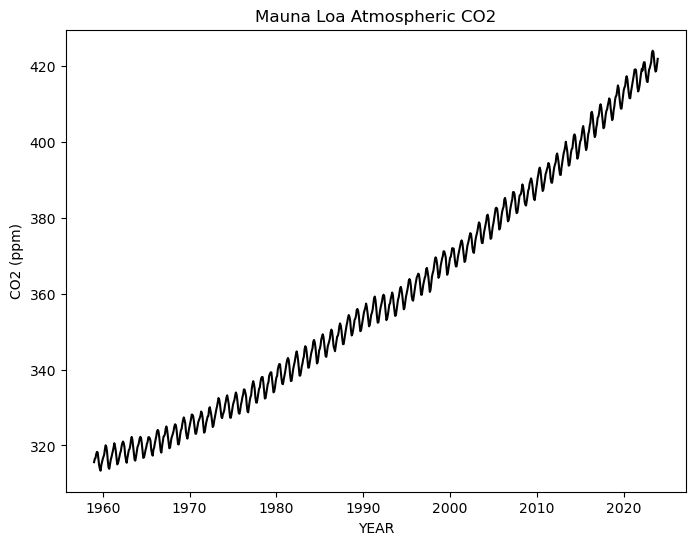

In [2]:
# get the CO2 data from the csv file
df = pd.read_csv('co2_mm_mlo.csv')

# combine 'year' and 'month' into a single new datetime column called 'date'
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # required to have 'day=1' here, which makes it a proper datetime value 

# now set the 'date' column as the index
df.set_index('date', inplace=True)

# now we can drop the columns that we aren't going to use - note you need to specify 'axis' for this drop operation
df.drop(['year', 'month'], axis=1, inplace=True) 

co2 = df['co2']

# and let's visualize our data
plt.figure(figsize=(8, 6))
plt.plot(co2,'k')
plt.xlabel('YEAR')
plt.ylabel('CO2 (ppm)')
plt.title('Mauna Loa Atmospheric CO2')
plt.show()


Here we build a function for the Butterworth digital filter.  The function combines several things we need to do for filtering.  First, it determines the normalized cutoff frequency, based on the time steps between samples (the sampling frequency, fs) and the requested cutoff frequency.  The function then gets the coefficients that describe the shape of the Butterworth filter itself.  The function also pads the data at either end, which helps minimiize end effects from the filtering.  The function then applies `filtfilt`, which pass the Butterworth filter we designed forward and backward over the time series (this improve the phase of the filter).  Finally, it removes the padding and returns the Pandas series with its datetime index intact:

In [3]:
def butterworth_filter(data, cutoff, fs, order=6, filter_type='low'):
    
    # get the Nyquist frequency
    nyquist = 0.5 * fs 
    
    # normalize the cutoff frequency (or frequencies if band-pass)
    normal_cutoff = np.array(cutoff) / nyquist

    # get the parameters for the Butterworth filter
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    
    # Now we pad the data at both ends to deal with possible edge effects - see here: https://numpy.org/doc/2.0/reference/generated/numpy.pad.html
    pad_len = len(data) # pad with length of series
    data_padded = np.pad(data,pad_len, mode="symmetric")  # should probably make 'mode' an input option
    
    # Apply backward-forward filter (filtfilt) to the padded data
    filtered_data_padded = filtfilt(b, a, data_padded)
    
    # Remove the padding to return the filtered data with the original length
    filtered_data = filtered_data_padded[pad_len:-pad_len]
    
    # Convert the filtered data back into a Pandas Series so it keeps the original (time) index
    filtered_series = pd.Series(filtered_data, index=data.index)
    
    return filtered_series

Let's apply the Butterworth filter above to our CO2 time series.  For now we'll just use the low-pass filter and the high--pass filteR:

In [4]:
# Sampling frequency - for monthly data, fs = 12, or '12 samples per year', which affects the normalized cutoff frequency)
fs = 12

# Performs the low-pass filter
cutoff_low = 0.05 
co2_lowpass = butterworth_filter(co2, cutoff_low, fs, order=6, filter_type='low')

# Now the high-pass filter
cutoff_high = 0.1  # You can adjust this cutoff value
co2_highpass = butterworth_filter(co2, cutoff_high, fs, order=6, filter_type='high')


And let's plot both of the filtered time series:

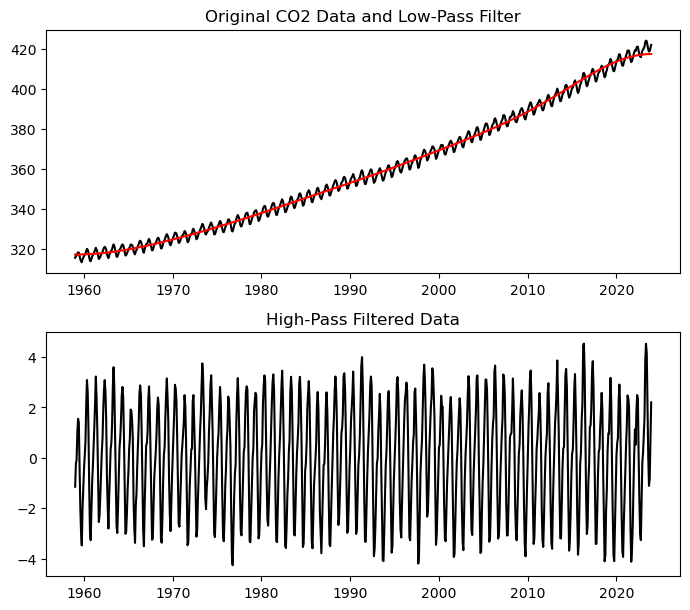

In [5]:
# Plot the original and filtered data
plt.figure(figsize=(7, 9))

# Plot the original CO2 data and the low-pas filter through it
plt.subplot(3, 1, 1)
plt.plot(co2, label='Original CO2 Data', color='black')
plt.plot(co2_lowpass, label='Low-Pass Filter', color='red')
plt.title('Original CO2 Data and Low-Pass Filter')

# Plot the high-pass filtered data separately 
plt.subplot(3, 1, 2)
plt.plot(co2_highpass, label='High-Pass Filter', color='black')
plt.title('High-Pass Filtered Data')

plt.tight_layout()
plt.show()

We can see that we've isolated the lowest frequency component (the non-linear trend) and the seasonal cycle using the low-pass and high-pass filter, respectively.  Notice that the end of the low-pass isn't perfectly fit.  Why do you think that might be?  How might you approach dealing with this? 

## Band-pass filter and the danger of filtering noise

As a demonstration of the band-pass filter, let's create and filter some very long series of Gaussian noise:

In [6]:
# set the random seed so we all get the same result in class
np.random.seed(1999)

# Generate long two arrays of random data
x = np.random.randn(1000)
y = np.random.randn(1000)

# Create an index that is time-like
index = pd.RangeIndex(start=0, stop=1000, step=1)

# Convert x and y to Pandas Series and add that index - this is out 'time' dimension
x_series = pd.Series(x, index=index, name='x')
y_series = pd.Series(y, index=index, name='y')


Let's plot the noise series - notice they (1) don't look anything alike, and (2) there is no evidence of periodic or cyclical behavior:

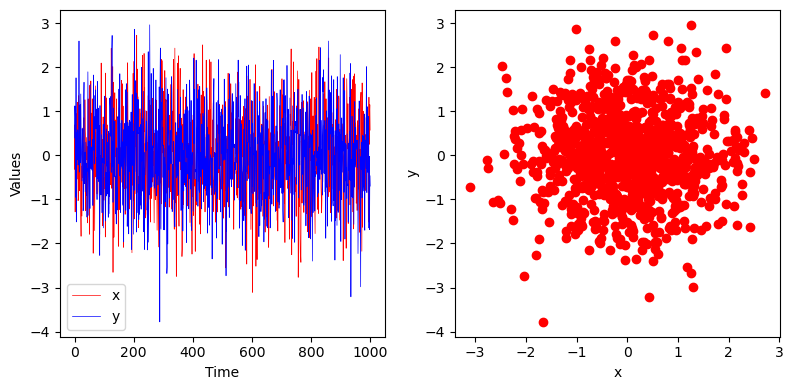

In [7]:
# Create a figure with two subplots 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4)) 

# First panel: Line plot of x and y over time
ax1.plot(x, '-r', linewidth=0.5, label='x')
ax1.plot(y, '-b', linewidth=0.5, label='y')
ax1.set_xlabel('Time')
ax1.set_ylabel('Values')
ax1.legend()

# Second panel: Scatter plot of x vs y
ax2.scatter(x, y,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.tight_layout()
plt.show()

Let's perform a band-pass filter now on both white noise series and plot the results:

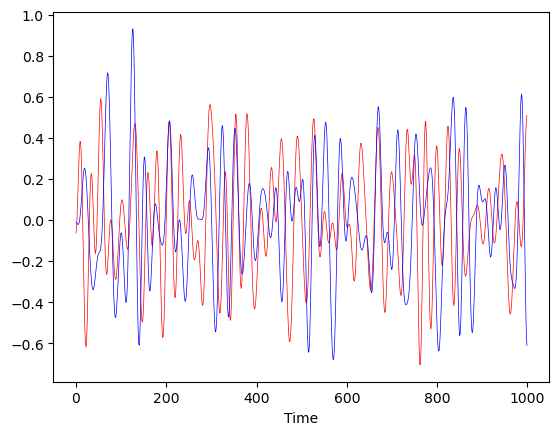

In [8]:
fs = 1 # no seasonality now, e.g looking at a sampling frequency of a a year

cutoff_low_band = 0.01
cutoff_high_band = 0.05

x_bandpass = butterworth_filter(x_series, [cutoff_low_band, cutoff_high_band], fs, order=6, filter_type='band')
y_bandpass = butterworth_filter(y_series, [cutoff_low_band, cutoff_high_band], fs, order=6, filter_type='band')

plt.plot(x_bandpass.index, x_bandpass, '-r', linewidth=0.5)
plt.plot(y_bandpass.index, y_bandpass, '-b', linewidth=0.5)
plt.xlabel('Time')
plt.show()

Notice that passing a filter over noise created the appearance of periodic or cyclical behavior.  You might even be tempted to look for places where both of our filtered series are in (or out) of sync.  But remember the underlying time series here are just noise!  With filtering comes great responsibility, which also applied to spectral analysis, which we'll do next week. 